In [23]:
# raytracing tutorial
# 04- basic sphere with phong lighting with matt surface added

In [24]:
import numpy
import matplotlib.pyplot as plt
import math

# plot images in this notebook
%matplotlib inline

In [25]:
# axes x to the right, y upwards. z into the screen (left hand rule)

In [26]:
# sphere object

class Sphere():
    
    def __init__(self, x, y, z, r):
        self.centre = numpy.array([x,y,z])
        self.radius = r
        pass
    
    def status(self):
        print("centre = ", self.centre)
        print("radius = ", self.radius)
        pass

    def intersection(self, camera_location, ray_direction_vector):
        # calculate quadratic determinant "b^2 - 4ac" for ray intersecting circle
        b = numpy.dot(2 * ray_direction_vector,(camera_location - self.centre))
        b2 = b*b
        a = numpy.dot(ray_direction_vector, ray_direction_vector)
        c = numpy.dot((self.centre - camera_location), (self.centre - camera_location)) - (self.radius * self.radius)
        delta = b2 - (4 * a * c)
        #print(delta)
        
        if (delta >= 0):
            # calculate nearest point (lowest t)
            t = (-b - math.sqrt(delta)) / (2 * a)
            intersection_point = camera_location + (t * ray_direction_vector)
            
            # calculate normal at surface
            normal = (intersection_point - self.centre) / numpy.linalg.norm(intersection_point - self.centre)
            
            # return tuple (intersection yes/no, nearest point, normal)
            return (delta>0, intersection_point, normal)
            pass
        
        # return tuple (intersection yes/no, nearest point, norm)
        return (delta >= 0, 0, 0)

In [27]:
# camera location
camera_location = numpy.array([0,0,-100])

# view port
view_port_location = numpy.array([-10, 0, 0])
view_port_width = 20
view_port_height = 20

# resolution (pixels per unit distance)
resolution = 40

In [28]:
# light source

# light is at above right, and a bit forward
light_location = numpy.array([100, 100, -50])


In [29]:
# create sphere
sphere = Sphere(0,10,10,5)
sphere.status()

centre =  [ 0 10 10]
radius =  5


In [30]:
# create image

image = numpy.zeros([view_port_width * resolution, view_port_height * resolution, 3], dtype='uint8')
print("image shape = ", image.shape)

image shape =  (800, 800, 3)


In [34]:
# main loop is to consider every pixel of the viewport

for pixel_ix in range(image.shape[0]):
    for pixel_iy in range(image.shape[1]):
        
        current_position = view_port_location + numpy.array([pixel_ix/resolution, pixel_iy/resolution, 0])
        #print("current_position", current_position)
        ray_direction_vector = current_position - camera_location
        ray_direction_vector /= numpy.linalg.norm(ray_direction_vector)
        #print(ray_direction_vector)
        
        # calculate  background sky pixel colour from vertical direction of ray
        colour = 100 + int(ray_direction_vector[1] *  3 * 255)
        image[pixel_ix, pixel_iy] = [50, 50, colour]
        
        # check intersection with sphere, then light using norm and light source
        intersection = sphere.intersection(camera_location, ray_direction_vector)
        if intersection[0]:
            # calculate rays
            norm = intersection[2]
            to_light_source = light_location - intersection[1]
            to_light_source /= numpy.linalg.norm(to_light_source)
            reflected_ray = (2 * numpy.dot(norm, to_light_source) * norm) - to_light_source
            
            # add small noise to reflected ray to simulate matt surface
            #print(reflected_ray)
            reflected_ray = reflected_ray + (numpy.random.randn(1,3)[0])
            reflected_ray /=  numpy.linalg.norm(reflected_ray)
            #print(reflected_ray)
            
            # calculate angle cosines
            cos_norm_to_lightsource = numpy.dot(norm, to_light_source) / (numpy.linalg.norm(to_light_source))
            cos_ray_to_reflection = numpy.dot(-ray_direction_vector, reflected_ray) / (numpy.linalg.norm(reflected_ray))
            
            # clip if below zero
            cos_norm_to_lightsource = numpy.clip(cos_norm_to_lightsource, 0, 1)
            cos_ray_to_reflection = numpy.clip(cos_ray_to_reflection, 0, 1)
            
            # apply power
            cos_norm_to_lightsource = math.pow(cos_norm_to_lightsource, 2)
            cos_ray_to_reflection = math.pow(cos_ray_to_reflection, 2)
            
            # combine factors
            lighting = (cos_norm_to_lightsource * cos_ray_to_reflection)
            # rescale from [-1,1] to [0, 127]
            lighting = (lighting + 1) / 2.0 * 127
            image[pixel_ix, pixel_iy] = [127 + lighting, lighting, lighting]
            pass
        
        pass
    pass

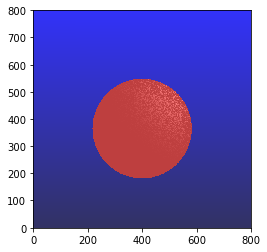

In [35]:
# transpose array so origin is bottom left, by swapping dimensions 0 and 1, but leave dimension 3

image2 = numpy.transpose(image, (1, 0, 2))
plt.imshow(image2, origin='lower')

In [36]:
plt.imsave('test.png', image2, origin='lower')